# Bayesian Inference with information content model check for Langevin Equations

We will analyse single particle tracking data for a certain model of Langevin Equations. Now we want to see and verify how well the model fits the data.

## Description of the Model

The Model is described below.

The langevin equation is given by 

$$ \boxed{\frac{d\hat{x}(t)}{dt} = \mu(\hat{x}) f + k_BT\frac{\partial\mu(\hat{x})}{\partial t} + \sqrt{2Dk_BT\mu(\hat{x})}\hat{\xi}(t)} $$

where $$ \boxed{\mu(\hat{x}) = D_0 |\hat{x}|^\alpha} $$

The corresponding Euler-Maruyuma Equation is given as

$$ \boxed{x(t+dt) = x(t) +D_0  |x(t)|^\alpha dt + k_B T \left(\alpha D_0 |x(t)|^{\alpha -1} \dfrac{x(t)}{|x(t)|}\right) dt+\sqrt{2D_0 k_B T |x(t)|^\alpha dt}\hat{N}(t)} $$

where $$ \hat{N}(t) \sim Normal (0,1) $$

## Generating Datasets

We will be working on artificial datasets on which we will be performing Bayesian Inference to get the parameters which we do not know.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numba import jit

In [2]:
# from the mu equation
D_0 = 0.2

# the initial starting point for the stochastic process
x_0 = 50

# MU = 0.1

#starting time for the process siumulation
t_0 = 0

#ending time for the process simulation
t_e = 100

#The alpha value in the mu equation
ALPHA_M = 1

# the value of f in the models given f=0(Free Model), and f=-0.3(pull Model) 
F_L = [0., -.3]

# the inverse of thermodynamic Beta set as k_BT = 1 for the paper.
k_BT =1

# no of steps
n = 100

# time step dt
DT = (t_e - t_0)/n

VAR_MN = [0, 0.5, 40]

In [3]:
@jit
def Model(num,t_end,F,D,ALPHA):
    y = np.zeros(num)
    y[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        y[i+1] = y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1)
        # The github code has values rounded to 3 values after the point
        # y[i+1] = np.round(y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1),3)
    return t, y 

In [4]:
@jit
def Model2(num,t_end,F,D,ALPHA):
    y = np.zeros(num)
    y[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        y[i+1] = y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA)) * np.random.normal(0,DT)
        # The github code has values rounded to 3 values after the point
        # y[i+1] = np.round(y[i] + D * (np.abs(y[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(y[i])**(ALPHA-1)*(y[i]/(np.abs(y[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(y[i])**ALPHA) *  DT) * np.random.normal(0,1),3)
    return t, y 

### $M_{clean}$ Model generation

These models do not take into account the measurement noise due to the instrument doing the collecting the SPT data.

#### $M_{clean, free}$ Model

Clean model with $f=0$

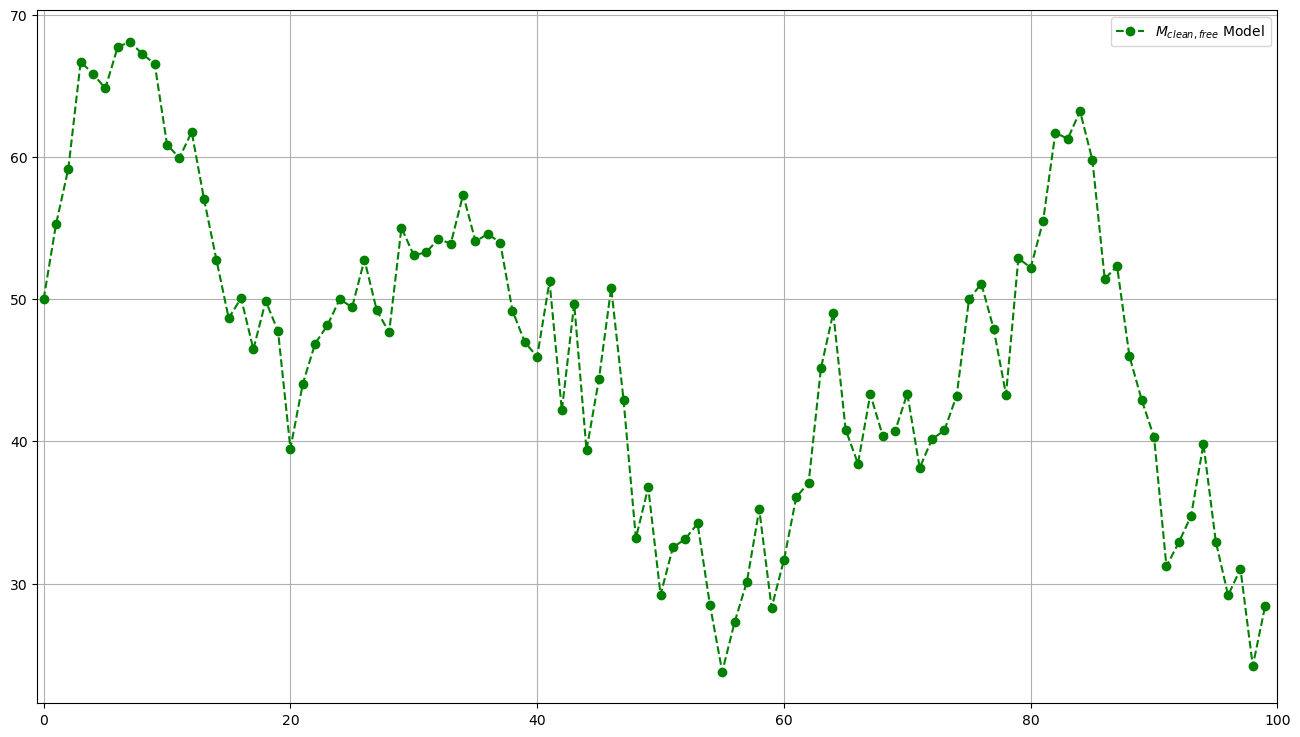

In [5]:
t_clean_free,x_clean_free = Model(n,t_e,F_L[0],D_0,ALPHA_M)

fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(t_clean_free,x_clean_free,'o--g',label = r"$M_{clean, free}$ Model")
axes.set_xlim((-0.5,100))
axes.legend()
axes.grid()

#### $M_{pull, free}$ Model

Clean model with $f=-0.3$

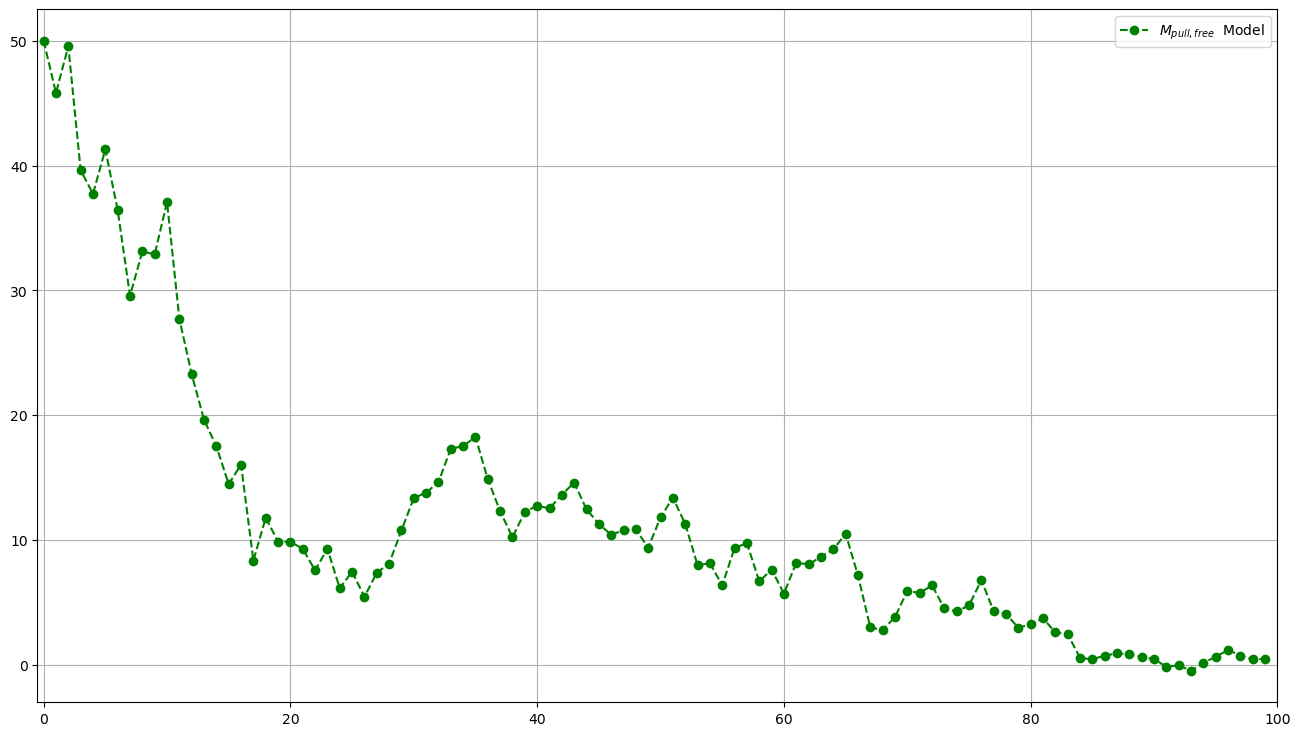

In [6]:
t_pull_free,x_pull_free = Model(n,t_e, F_L[1],D_0,ALPHA_M)
fig,axes = plt.subplots(1,1,figsize=(16,9))
axes.plot(t_pull_free,x_pull_free,'o--g',label = r"$M_{pull, free}$  Model")
axes.set_xlim((-0.5,100))
axes.legend()
axes.grid()   

### Measurement noise

In [7]:
@jit
def NoisyModel(num,t_end,F,D,ALPHA, VARN):
    y = np.zeros(num)
    ytrue = np.zeros(num)
    y[0] = x_0
    ytrue[0] = x_0
    DT = (t_end-t_0)/num
    t = np.arange(t_0, t_end ,DT)
    for i in range(0,num-1):
        ytrue[i+1] = ytrue[i] + D * (np.abs(ytrue[i])**ALPHA) * F * DT + k_BT * (ALPHA * D * ((np.abs(ytrue[i])**(ALPHA-1)*(ytrue[i]/(np.abs(ytrue[i]))))))* DT+ np.sqrt(2 * D * k_BT * (np.abs(ytrue[i])**ALPHA) *  DT) * np.random.normal(0,1)
        y[i+1] = ytrue[i+1] + np.random.normal(0,VARN)
    return t, y, ytrue

## Likelihood calculations of the datasets

$$ \boxed{P(\theta | D) = \Pi_{j=0}^{N} \frac{1}{\sqrt{2 \pi \sigma_j^2}} \exp\left(\frac{-(x_j - \langle x_j \rangle)^2)}{2 \sigma_j^2}\right)} $$

Where

$\sigma_i = 2  k_B  T  D  (\lvert x_{i-1} \rvert^\alpha)  dt$ and 

$  \langle x_i\rangle = x_{i-1} + \left( (\lvert x_{i-1} \rvert^\alpha)  f + k_B T (\alpha  D  (\lvert x_{i-1} \rvert^{\alpha-1}  (\text{sgn}(x_{i-1}))) \right)  dt $

In [8]:
# @jit
# def likelihoodcalc(x_coord,DT,D,F,ALPHA):
#     PROB = 1
#     std_dev = np.zeros(n+1)
#     mean_dist = np.zeros(n+1)
#     for i in range(1,n+1):
#         std_dev[i] = 2 * k_BT * D * (np.abs(x_coord[i-1])**ALPHA) * DT
#         mean_dist[i] = x_coord[i-1] + ((np.abs(x_coord[i-1])**ALPHA) * F + k_BT * (ALPHA * D * (np.abs(x_coord[i-1])**(ALPHA-1)*(np.sign(x_coord[i-1])))))* DT
#         PROB *= 1/np.sqrt(2 * np.pi * std_dev[i]) * np.exp((-(x_coord[i] - mean_dist[i])**2)/(2 * std_dev[i]))
#     return PROB

In [9]:
# @jit
# def log_likelihoodcalc(x_coord,DT,D,F,ALPHA):
#     PROB = 0
#     std_dev = np.zeros(n+1)
#     mean_dist = np.zeros(n+1)
#     for i in range(1,n+1):
#         std_dev[i] = 2 * D * (np.abs(x_coord[i-1])**ALPHA) * DT
#         mean_dist[i] = x_coord[i-1] + ((np.abs(x_coord[i-1])**ALPHA) * F * (ALPHA * D * (np.abs(x_coord[i-1])**(ALPHA-1)*(np.sign(x_coord[i-1])))))* DT
#         PROB += -0.5 * np.log(2 * np.pi * std_dev[i]) -((x_coord[i] - mean_dist[i])**2)/(2 * std_dev[i])
#     return PROB

In [10]:
@jit
def noisylikelihoodcalc(x_coord,DT,D,F,ALPHA, varmn):
    n = len(x_coord)
    logl = 0
    

    # Noise measurement changes
    std_dev_noise = 2 * D * (np.abs(x_coord[0])**ALPHA) * DT + 2 * varmn
    noisy_mean = x_coord[0] + ((np.abs(x_coord[0])**ALPHA) * F + k_BT * (ALPHA * D * ((np.abs(x_coord[0])**(ALPHA-1))*(np.sign(x_coord[0])))))* DT
    

    logl -= ((x_coord[1] - noisy_mean)**2)/(2 * std_dev_noise) + 0.5 * np.log(2 * np.pi * std_dev_noise)
    
    for i in range(2,n):
        std_dev = 2 * D * (np.abs(x_coord[i-1])**ALPHA) * DT
        mean_dist = x_coord[i-1] + ((np.abs(x_coord[i-1])**ALPHA) * F + ALPHA * D * (np.abs(x_coord[i-1])**(ALPHA-1))*(np.sign(x_coord[i-1])))* DT 
        noisy_mean = mean_dist - varmn/(std_dev_noise) * (x_coord[i-1] - noisy_mean)
        std_dev_noise = std_dev + varmn*(2 - varmn/std_dev_noise)
        
        logl = logl -((x_coord[i] - noisy_mean)**2)/(2 * std_dev_noise) - 0.5 * np.log(2 * np.pi * std_dev_noise)
    
    return logl

In [11]:
def SDE_logl_m(obs, theta, n):
    T = len(obs)
    D = theta[0]
    a = theta[1]
    f = theta[2]
    var_n = theta[3]  
    
    logl = 0
    mob = D * abs(obs[0])**a
    mean_x = f * mob + np.sign(obs[0]) * a * D * abs(obs[0])**(a - 1)
    mean_x = mean_x * n
    F = obs[1] - obs[0] - mean_x
    var_d = 2 * mob
    var_tot = 2 * var_n + var_d * n
    logl = logl - np.log(np.sqrt(2 * np.pi * var_tot)) - F**2 / (2 * var_tot)

    for t in range(2, T):
        mob = D * abs(obs[t - 1])**a
        var_d = 2 * mob
        mean_x = f * mob + np.sign(obs[t - 1]) * a * D * abs(obs[t - 1])**(a - 1)
        mean_x = mean_x * n
        mean_x = mean_x - var_n / var_tot * F
        F = obs[t] - obs[t - 1] - mean_x
        var_tot = var_d * n + 2 * var_n - var_n**2 / var_tot
        logl = logl - np.log(np.sqrt(2 * np.pi * var_tot)) - F**2 / (2 * var_tot)

    return logl

In [12]:
N = 1000
n = 100

# time step dt
DT = (t_e - t_0)/n

# log likelihood array initialization
logPROBD = np.zeros(N)
logPROBA = np.zeros(N)
logPROBF = np.zeros(N)
logPROBMN = np.zeros(N)

alpha_range = np.linspace(0, 2, N)
d_range=np.linspace(0.1,2,N)
F_L_range=np.linspace(-1,1,N)
MN_range = np.linspace(0, 10, N)

varmntemp = 0
# p_data = [50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926]
t_clean_free,xmeasured, xtrue = NoisyModel(n,t_e,F_L[0],D_0,ALPHA_M,varmntemp)

# theta = [D_0, ALPHA_M,F_L[0], 10]
# varmntemp = VAR_MN[0]
for i in range(0,N):
    
    logPROBF[i] = noisylikelihoodcalc(xmeasured,DT,D_0,F_L_range[i],ALPHA_M, varmntemp)

    logPROBD[i] = noisylikelihoodcalc(xmeasured,DT,d_range[i],F_L[0],ALPHA_M, varmntemp)
    
    logPROBA[i] = noisylikelihoodcalc(xmeasured,DT,D_0,F_L[0],alpha_range[i], varmntemp)
    
    logPROBMN[i] = noisylikelihoodcalc(xmeasured,DT,D_0,F_L[0],ALPHA_M, MN_range[i])

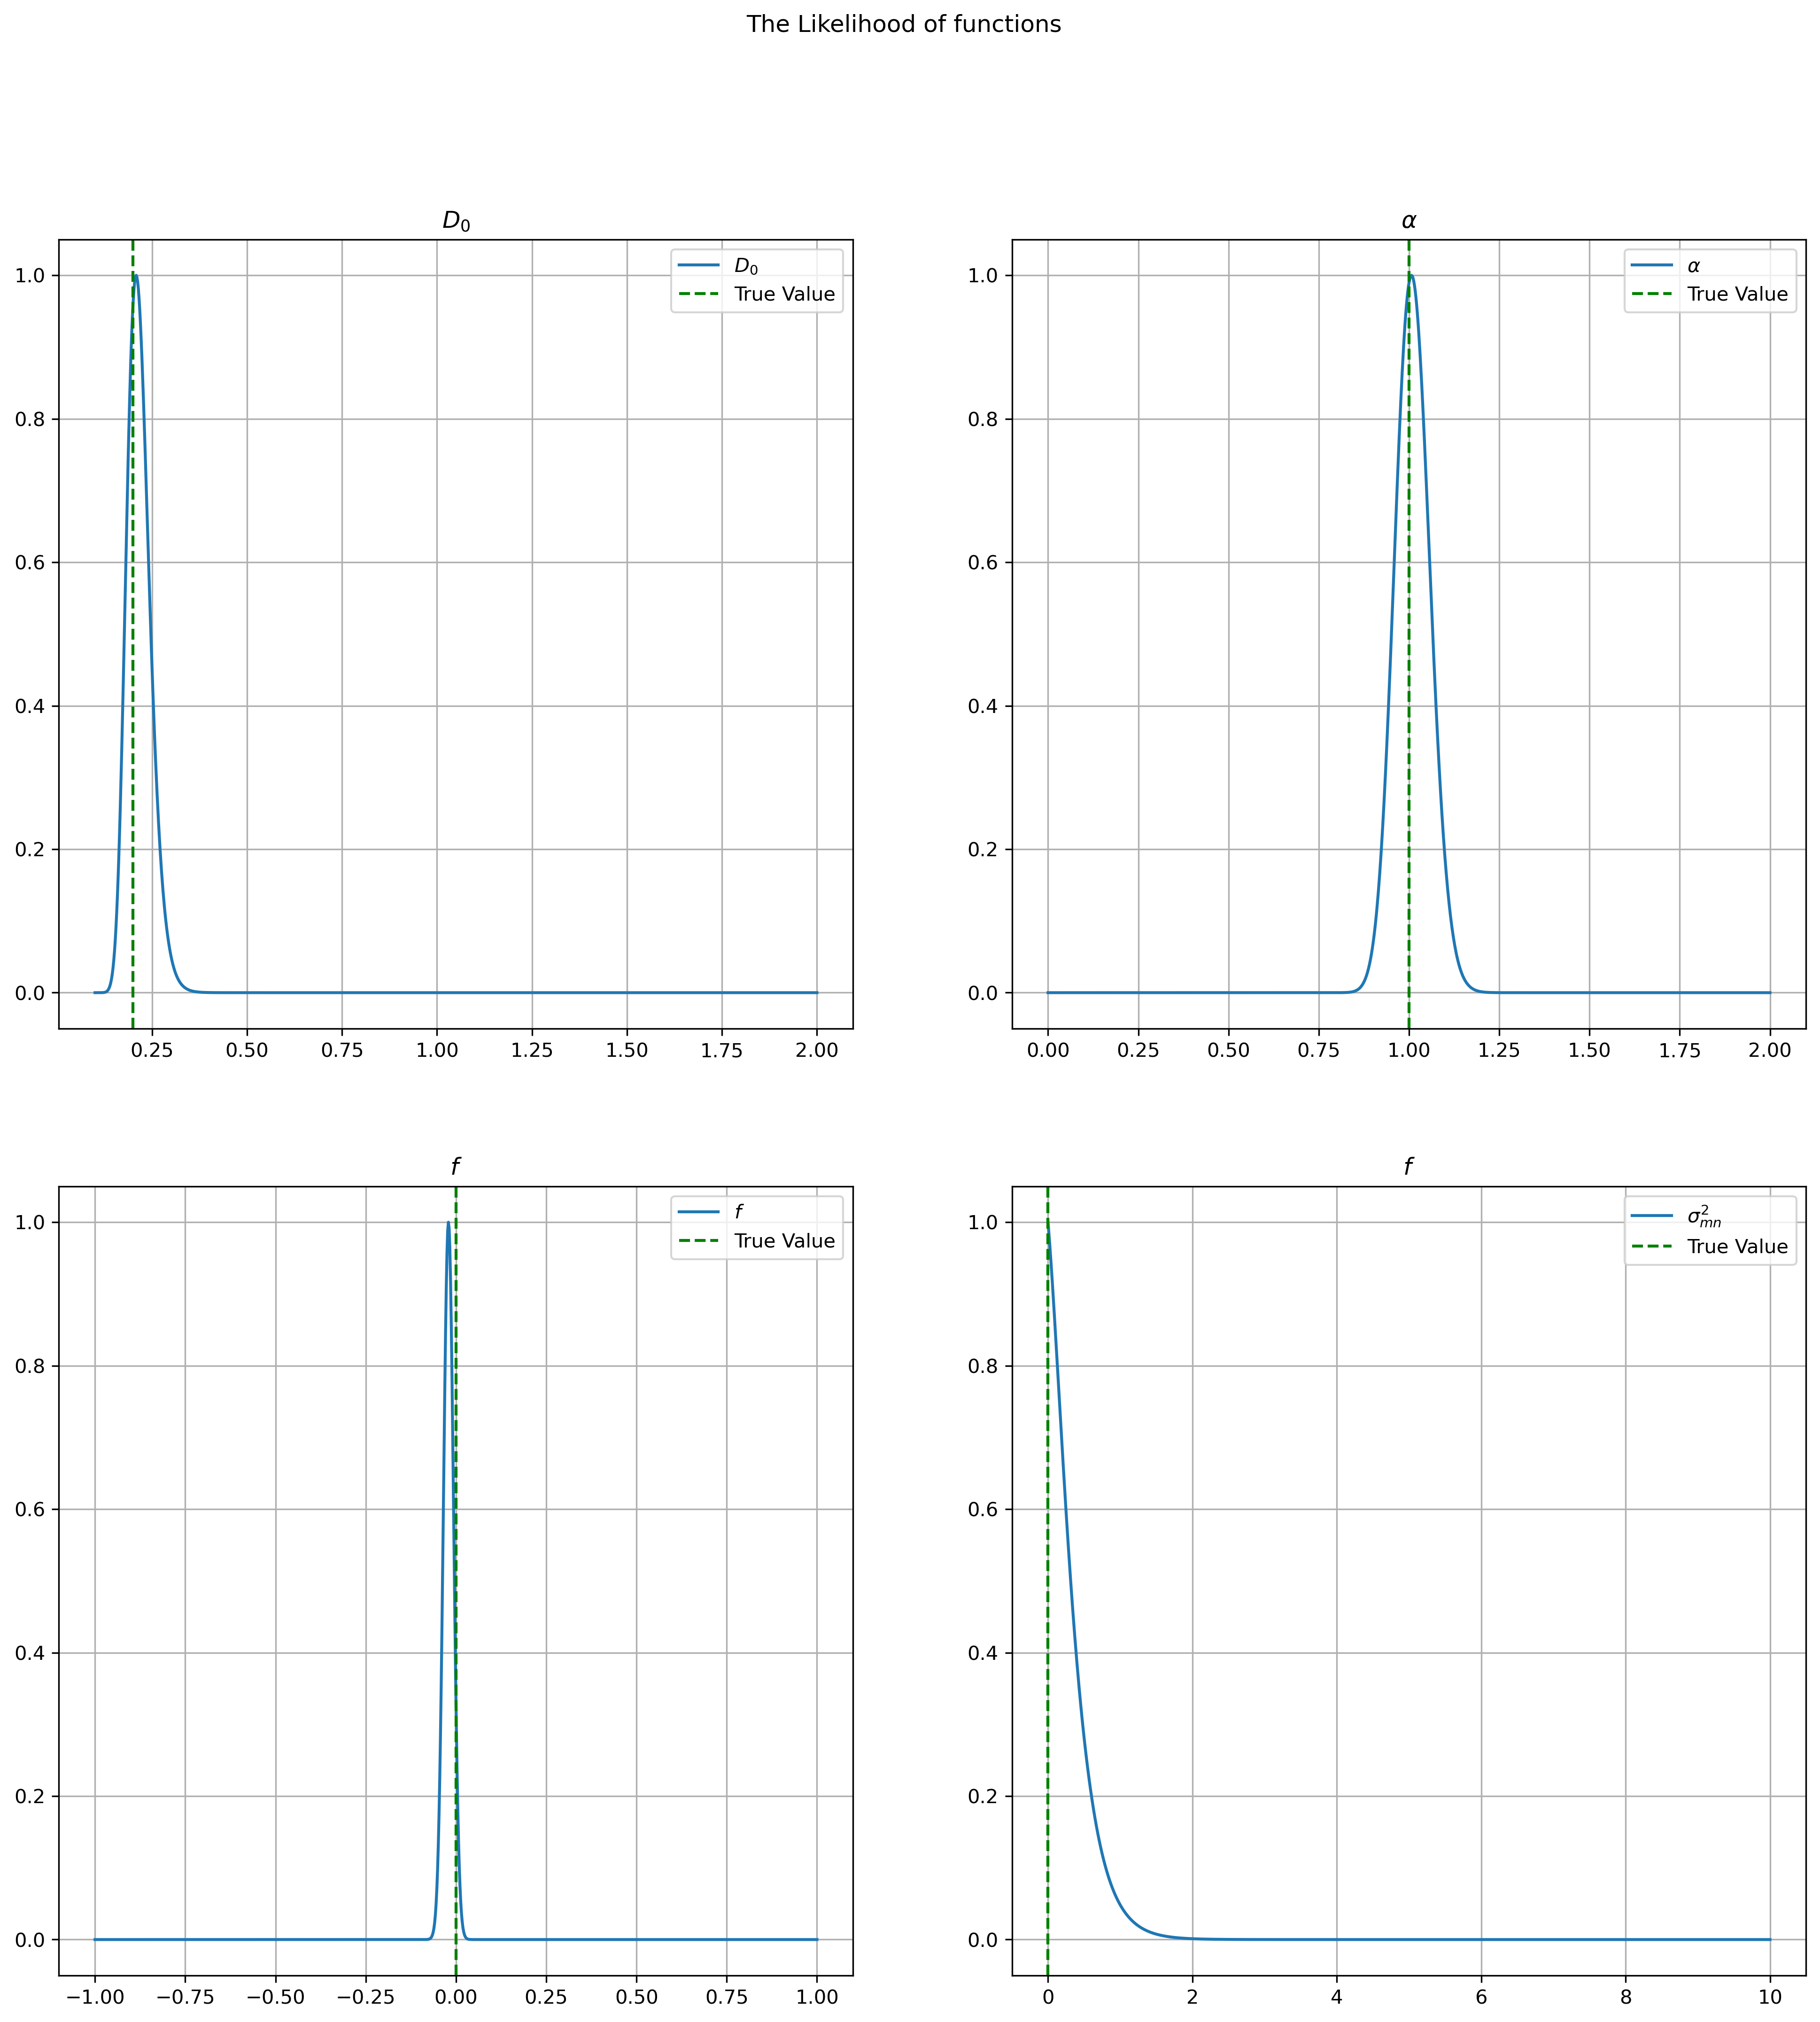

In [13]:
llA = np.exp(logPROBA - max(logPROBA))
llD = np.exp(logPROBD - max(logPROBD))
llF = np.exp(logPROBF - max(logPROBF))
llMN = np.exp(logPROBMN - max(logPROBMN))
mllA = d_range[np.where(llA == 1)[0][0]]

fig, axes = plt.subplots(2, 2, figsize = (16, 16), dpi = 300)
plt.suptitle("The Likelihood of functions")

axes[0][0].plot(d_range, llD, label = r"$D_0$")
axes[0][0].axvline(x = D_0,ls ='--', color = 'g', label = "True Value")
axes[0][0].set_title(r"$D_0$")
axes[0][0].grid()
axes[0][0].legend()

axes[0][1].plot(alpha_range, llA, label = r"$\alpha$")
axes[0][1].axvline(x = ALPHA_M,ls ='--', color = 'g', label = "True Value")
axes[0][1].set_title(r"$\alpha$")
axes[0][1].grid()
axes[0][1].legend()

axes[1][0].plot(F_L_range, llF, label = r"$f$")
axes[1][0].axvline(x = F_L[0],ls ='--', color = 'g', label = "True Value")
axes[1][0].set_title(r"$f$")
axes[1][0].grid()
axes[1][0].legend()

axes[1][1].plot(MN_range, llMN, label = r"$\sigma^2_{mn}$")
axes[1][1].axvline(x = varmntemp,ls ='--', color = 'g', label = "True Value")
axes[1][1].set_title(r"$f$")
axes[1][1].grid()
axes[1][1].legend()

In [353]:
N = 100000
n = 100000

# time step dt
DT = (t_e - t_0)/n
PROBD = np.zeros(N)
PROBA = np.zeros(N)
PROBF = np.zeros(N)
alpha_range = np.linspace(-0., 3, N)
d_range=np.linspace(0.1,2,N)
F_L_range=np.linspace(-1,1,N)

t_pull_free,x_pull_free = Model(n,t_e,F_L[1],D_0,ALPHA_M)

for i in range(0,N):
    PROBD[i] = likelihoodcalc(x_pull_free,DT,d_range[i],F_L[1],ALPHA_M)
    PROBA[i] = likelihoodcalc(x_pull_free,DT,D_0,F_L[1],alpha_range[i])
    PROBF[i] = likelihoodcalc(x_pull_free,DT,D_0,F_L_range[i],ALPHA_M)

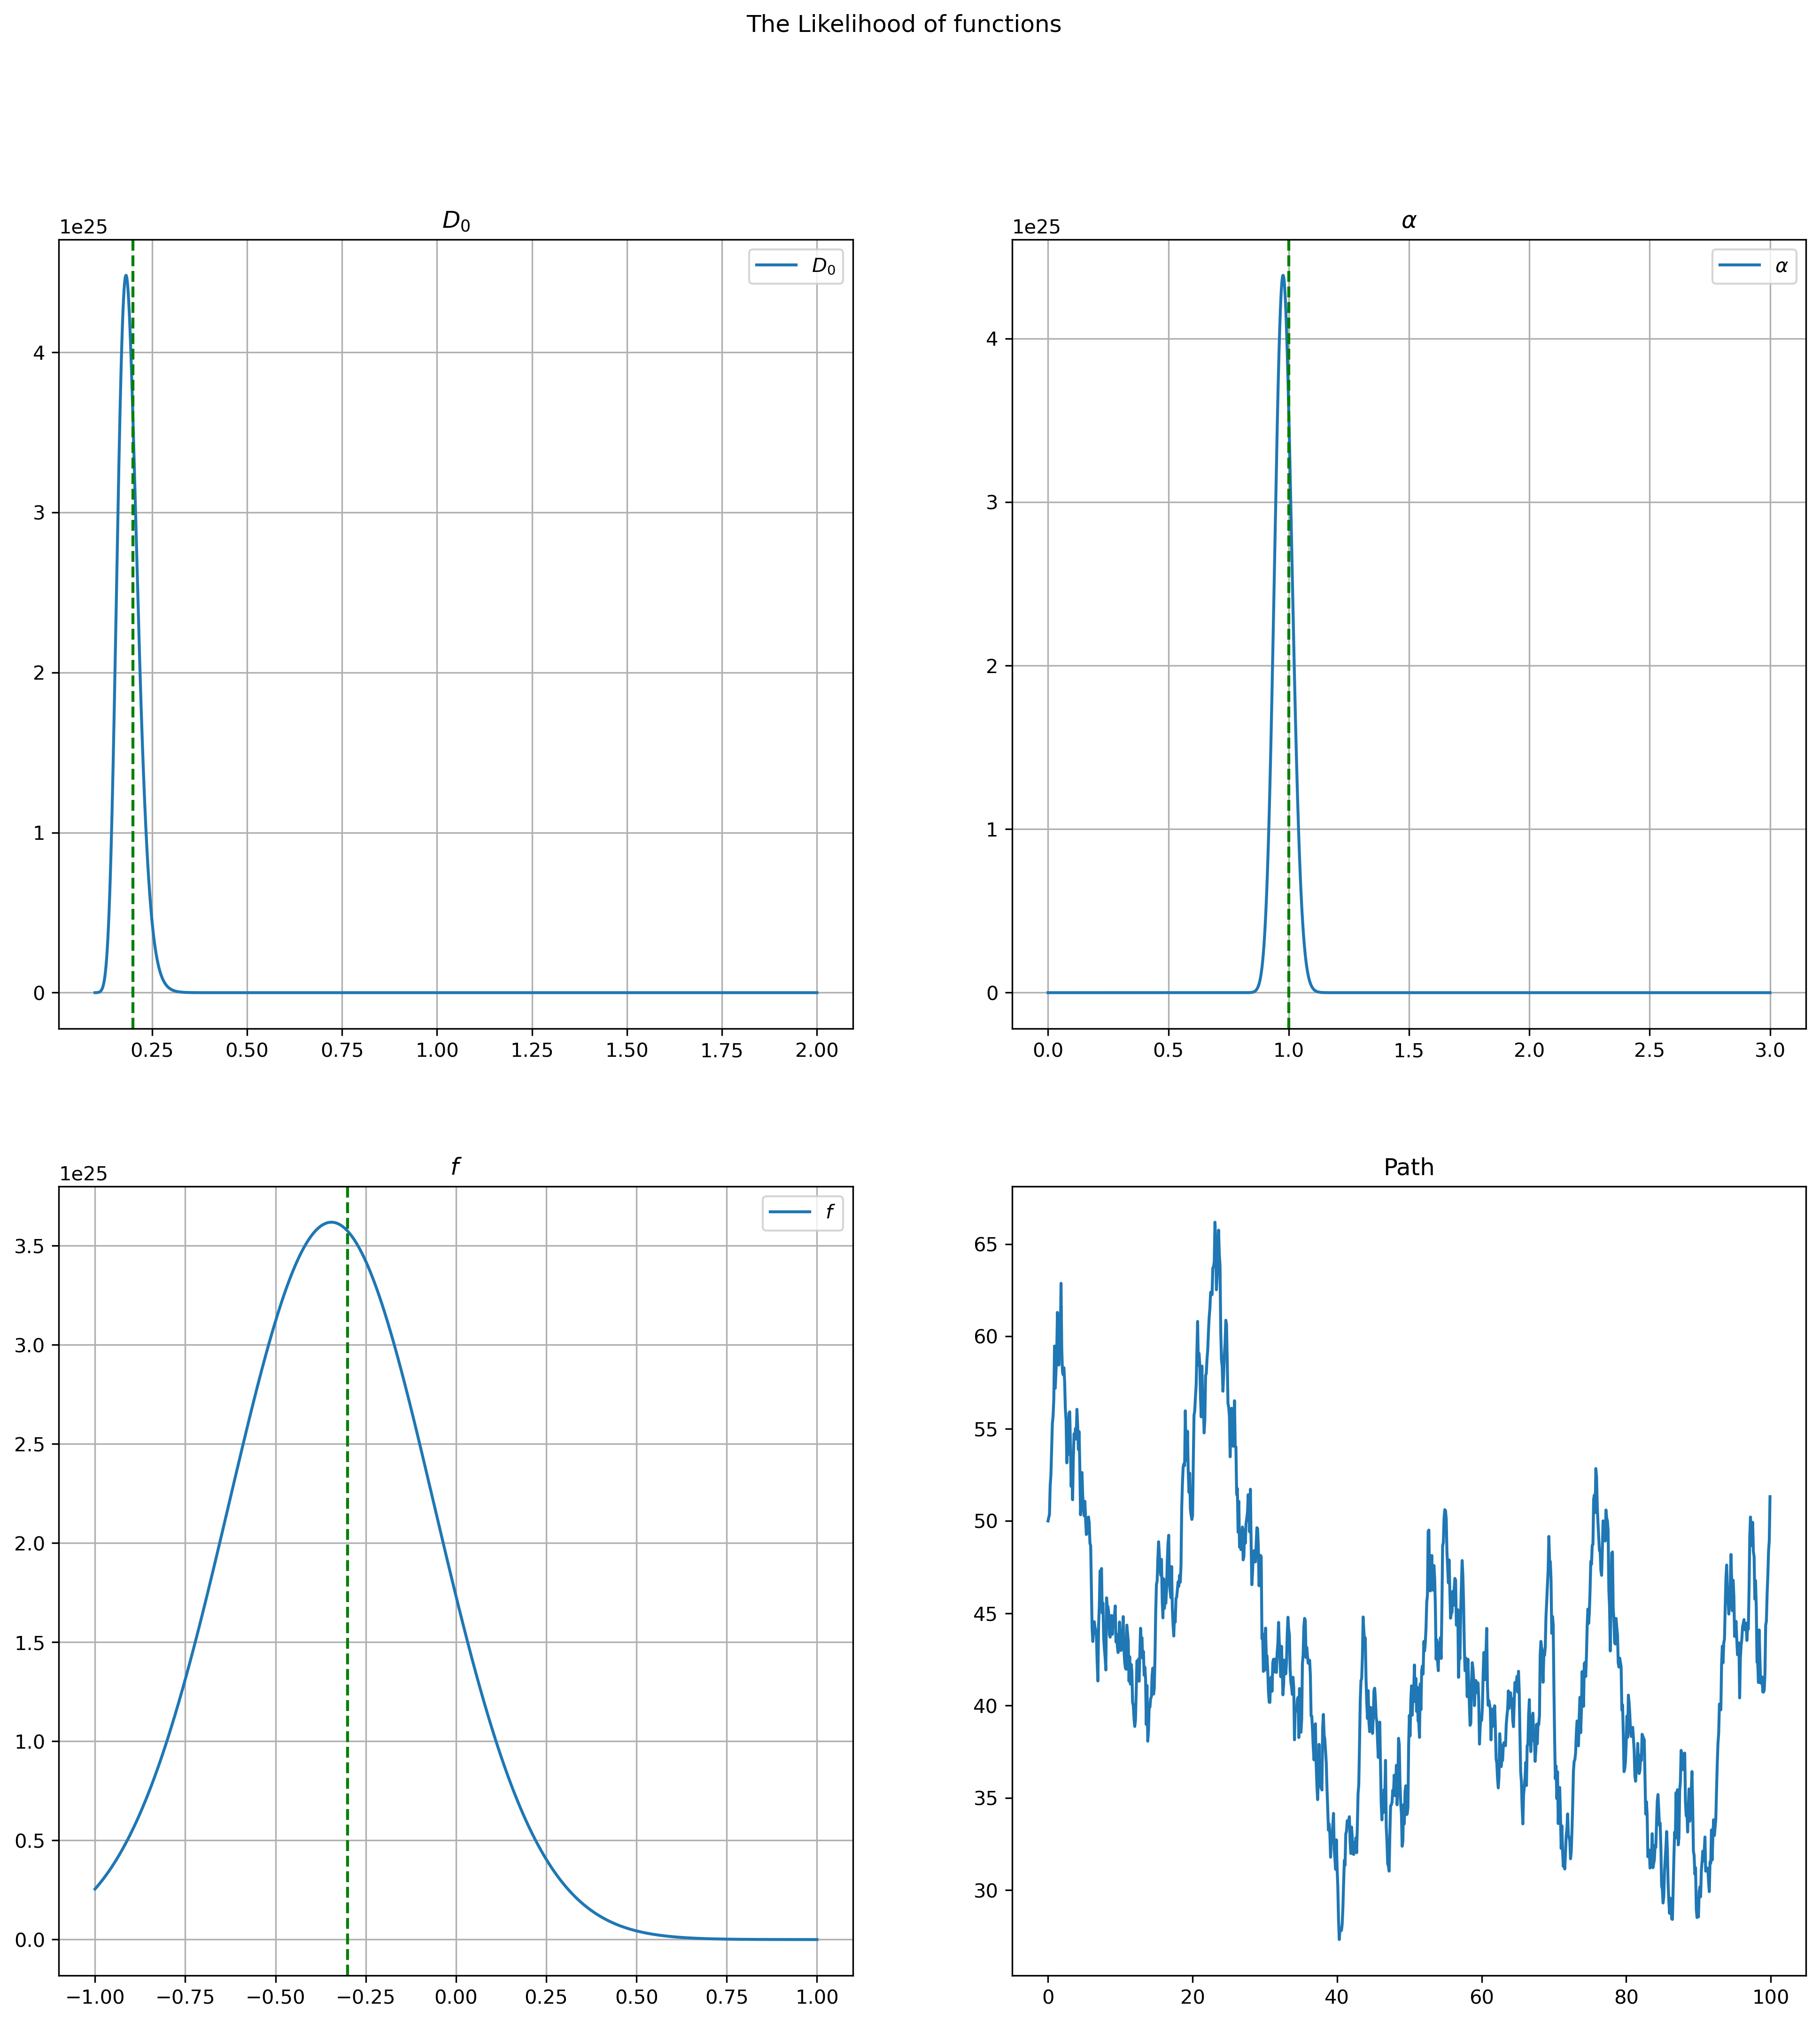

In [355]:
fig, axes = plt.subplots(2, 2, figsize = (16, 16), dpi = 300)
plt.suptitle("The Likelihood of functions")

axes[0][0].plot(d_range, PROBD, label = r"$D_0$")
axes[0][0].axvline(x = D_0,ls ='--', color = 'g')
axes[0][0].set_title(r"$D_0$")
axes[0][0].grid()
axes[0][0].legend()

axes[0][1].plot(alpha_range, PROBA, label = r"$\alpha$")
axes[0][1].axvline(x = ALPHA_M,ls ='--', color = 'g')
axes[0][1].set_title(r"$\alpha$")
axes[0][1].grid()
axes[0][1].legend()

axes[1][0].plot(F_L_range, PROBF, label = r"$f$")
axes[1][0].axvline(x = F_L[1],ls ='--', color = 'g')
axes[1][0].set_title(r"$f$")
axes[1][0].grid()
axes[1][0].legend()

axes[1][1].plot(t_clean_free,x_clean_free)
axes[1][1].set_title("Path");